# 6.0 Reload merged data and rebuild train/valid split

Because this is a new notebook, variables such as `X_train`, `X_valid`, `y_train`, and `y_valid`
from Notebook 4 are not in memory anymore.

In this step, we:
- Reload the merged training data from `outputs_merged/train_merged.parquet`.
- Select the same numeric feature set as in Section 4.1.
- Recreate the stratified train/validation split with the same `random_state=42`
  so that our training/validation partition is consistent with the midterm experiments.

In [53]:
# === 6.0 Reload merged data and basic train/valid split ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load merged training data
train_path = "outputs_merged/train_merged.parquet"
df = pd.read_parquet(train_path)

print("Loaded merged train:", df.shape)
print("CTR (positive rate):", df['label'].mean())

target = "label"

# Select numeric columns (same as in Section 4.1)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target]

X_all = df[numeric_cols].copy()
y_all = df[target].astype(int).copy()

print(f"Using {len(numeric_cols)} numeric features.")
print("Sample numeric cols:", numeric_cols[:10])

# Normal train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

print("Train size:", X_train.shape, "Valid size:", X_valid.shape)
print("Valid CTR:", y_valid.mean())

Loaded merged train: (7675517, 68)
CTR (positive rate): 0.01552156030662169
Using 60 numeric features.
Sample numeric cols: ['log_id', 'user_id', 'age', 'gender', 'residence', 'city', 'city_rank', 'series_dev', 'series_group', 'emui_dev']
Train size: (6140413, 60) Valid size: (1535104, 60)
Valid CTR: 0.01552142395564079


# 6.1 Prepare Training Data for Synthetic Generation

In this section, we prepare a clean, leakage-free dataset for training tabular data synthesizers.
Following the feature-selection procedures in Section 4.6.2, we use the Safe Top-27 features obtained from Random Forest and LightGBM. These features exclude identifiers (log_id, user_id) and the raw timestamp pt_d, avoiding unintended leakage and ensuring that the synthesizers learn meaningful behavioral patterns.

We construct the training matrix using:
	•	The Safe Top-27 numerical features
	•	The binary label (label)
	•	No scaling is required, as the synthesizers operate directly on numerical tabular data.

This dataset becomes the unified input for all generative models used later (GAN, VAE, Diffusion, and LLM-based synthesizers).


In [55]:
# === 6.1 Prepare cleaned dataset (Safe Top-27 features) ===
# Safe Top-27 features selected earlier (from Section 4.6)
safe_top_feats = [
    'creat_type_cd','f_cat_uniq','f_refresh_sum','slot_id','f_rows',
    'f_up_sum','f_dislike_sum','f_refresh_mean','u_refreshTimes',
    'u_newsCatInterestsST_len','f_up_mean','u_feedLifeCycle',
    'u_newsCatInterestsST_uniq','f_entities_len_mean','f_dislike_mean',
    'f_browser_life','adv_prim_id','device_size','adv_id','task_id',
    'inter_type_cd','hispace_app_tags','spread_app_id','app_second_class',
    'ad_click_list_v002_uniq','ad_click_list_v002_len','f_hour_cos'
]

# Keep only Safe Top-27 + label
df_clean = df[safe_top_feats + ["label"]].copy()

print("Clean dataset:", df_clean.shape)
df_clean.head()

Clean dataset: (7675517, 28)


,creat_type_cd,f_cat_uniq,f_refresh_sum,slot_id,f_rows,f_up_sum,f_dislike_sum,f_refresh_mean,u_refreshTimes,u_newsCatInterestsST_len,...,adv_id,task_id,inter_type_cd,hispace_app_tags,spread_app_id,app_second_class,ad_click_list_v002_uniq,ad_click_list_v002_len,f_hour_cos,label
0,6,4,0,46,5,44,27,0.0,0,3,...,19319,14339,4,47,162,14,3,3,-0.707107,0
1,8,4,0,37,5,44,27,0.0,0,3,...,21714,11923,4,20,344,13,3,3,-0.707107,1
2,8,4,0,37,5,44,27,0.0,0,3,...,21714,11923,4,20,344,13,3,3,-0.707107,1
3,8,4,0,47,5,44,27,0.0,0,3,...,20163,28665,4,49,152,17,3,3,-0.707107,0
4,8,4,0,44,5,44,27,0.0,0,3,...,13608,34041,4,43,312,18,3,3,-0.707107,0


# 6.2 Train / Validation Split for Synthesizers

To evaluate the quality of synthetic data later, we reserve a hold-out real validation set that is never seen by the synthesizers.
This preserved real data will be used for:
	•	Privacy evaluation
(distance-to-closest-record, membership inference tests)
	•	Utility evaluation
(train LightGBM on synthetic data → test on real validation set)
	•	Fidelity evaluation
(distribution matching, KS-tests, PCA plots, etc.)

We perform a stratified 80/20 split to preserve the CTR distribution.

In [57]:
from sklearn.model_selection import train_test_split

X = df_clean.drop(columns=["label"])
y = df_clean["label"]

X_train_syn, X_val_real, y_train_syn, y_val_real = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Synthetic training area :", X_train_syn.shape)
print("Real validation set     :", X_val_real.shape)
print("CTR (train):", y_train_syn.mean(), "CTR(valid):", y_val_real.mean())

Synthetic training area : (6140413, 27)
Real validation set     : (1535104, 27)
CTR (train): 0.01552159439438357 CTR(valid): 0.01552142395564079


# 6.3 Training a Tabular GAN (CTGAN)
In this section, we train our first tabular data synthesizer based on a Generative Adversarial Network (GAN).
We use CTGAN, a widely used model for mixed-type tabular data (continuous + discrete).

Goals of this part:
	1.	Build a clean training table that includes
	•	the Safe Top-27 features (Section 4.6.2)
	•	the binary label label
	2.	Identify discrete columns (categorical-like integer codes) for CTGAN.
	3.	Train a CTGAN model on the training split (X_train_syn, y_train_syn).
	4.	Generate a synthetic dataset of the same size as the training data.
	5.	Save the resulting synthetic table for later evaluation (utility, fidelity, and privacy).

We intentionally do not let the synthesizer see the held-out real validation set (X_val_real), so that all downstream evaluations remain fair and unbiased.

In [7]:
# === 6.3.1 Install and import CTGAN ===
# !pip install ctgan -U

import pandas as pd
from ctgan import CTGAN

### 6.3.1 Build CTGAN Training Table (Safe Top-27 + label)

In this part, we prepare the **training DataFrame** for CTGAN.

We will:
- Reuse the **Safe Top-27 features** selected in Section 4.6.2 (after removing leakage features like `log_id`, `user_id`, `pt_d`).
- Use **only the training split** (`X_train`, `y_train`) to avoid any validation leakage.
- Concatenate the features and the binary label into a single table `train_ctgan`.
- Optionally downsample to a manageable size for GAN training (e.g., 1M rows), because CTGAN training on the full 6M+ rows can be very slow on a single machine.

This `train_ctgan` table will be the input for fitting our CTGAN synthesizer in the next step.

In [94]:
# === 6.3.2 Build CTGAN training table (direct 200k sample) ===
# We directly sample 200k real rows for CTGAN training
N_TRAIN_CTGAN = 200_000

ctgan_train_df = pd.concat(
    [X_train_syn.reset_index(drop=True),
     y_train_syn.reset_index(drop=True)],
    axis=1
).sample(
    n=N_TRAIN_CTGAN,
    random_state=42
).reset_index(drop=True)

print("[CTGAN] Real subset for training:", ctgan_train_df.shape)
print("Positive rate:", ctgan_train_df["label"].mean())

# Save 200k REAL dataset for teammates
ctgan_train_df.to_csv("real_train_ctgan_200k_safe27.csv", index=False)
print("Saved REAL 200k training subset -> real_train_ctgan_200k_safe27.csv")

[CTGAN] Real subset for training: (200000, 28)
Positive rate: 0.015375
Saved REAL 200k training subset -> real_train_ctgan_200k_safe27.csv


### 6.3.2 Detect discrete (categorical) columns for CTGAN

In this step we:
	•	Take the CTGAN training table train_ctgan_sample (Safe Top-27 features + label).
	•	Automatically infer which columns are categorical (discrete).
	•	Build a discrete_columns list to pass into CTGAN.fit(df, discrete_columns=...).

Heuristics we use:
	•	label is always discrete.
	•	Any integer-type column with not too many unique values (e.g. <= 1000) is treated as discrete.
	•	Other columns (typically float features) are kept as continuous.

In [61]:
# === 6.3.2 Detect discrete columns ===
from pandas.api import types as pdt

ctgan_df = ctgan_train_df.copy()
discrete_columns = []

for col in ctgan_df.columns:
    # label is always discrete
    if col == "label":
        discrete_columns.append(col)
        continue

    # integer columns with limited unique values are discrete
    if pdt.is_integer_dtype(ctgan_df[col]):
        if ctgan_df[col].nunique() <= 1000:
            discrete_columns.append(col)

print("CTGAN training table shape:", ctgan_df.shape)
print("Number of discrete columns:", len(discrete_columns))
print("Discrete columns:", discrete_columns)

CTGAN training table shape: (200000, 28)
Number of discrete columns: 18
Discrete columns: ['creat_type_cd', 'f_cat_uniq', 'slot_id', 'f_rows', 'f_dislike_sum', 'u_refreshTimes', 'u_newsCatInterestsST_len', 'u_feedLifeCycle', 'u_newsCatInterestsST_uniq', 'adv_prim_id', 'device_size', 'inter_type_cd', 'hispace_app_tags', 'spread_app_id', 'app_second_class', 'ad_click_list_v002_uniq', 'ad_click_list_v002_len', 'label']


### 6.3.3 Train CTGAN (lighter config with `pac=1`)

In this step, we actually train a CTGAN model on the sampled training table.

Key design choices:

- **Smaller training subset** (`ctgan_train_df`): we only use up to 200k rows to make
  CTGAN training feasible on a single machine.
- **Discrete columns**: we reuse the `discrete_columns` list detected in Section 6.3.3
  so that CTGAN can correctly handle categorical variables via Gumbel–Softmax.
- **`pac=1`**: the original CTGAN implementation requires that every batch size be divisible
  by the `pac` parameter. By setting `pac=1`, we avoid assertion errors such as
  `input_.size()[0] % self.pac == 0` and make training more robust.
- **Lightweight training config**: we start with only 10 epochs and a batch size of 1024.
  This is enough to obtain a usable synthetic-data generator. Later, if time and compute allow,
  we can increase the number of epochs or the training sample size.

The trained CTGAN model is then saved to disk (`ctgan_safe_top27_small.pkl`)
so that later steps (synthetic sample generation, fidelity/utility/privacy evaluation)
can reload and reuse it without re-training.

In [63]:
from ctgan import CTGAN
import pickle

# Safety check
needed_vars = ["ctgan_train_df", "discrete_columns"]
for v in needed_vars:
    if v not in globals():
        raise RuntimeError(f"{v} missing. Please run 6.3.2 and 6.3.3.")

print(f"[CTGAN] Using {len(ctgan_train_df):,} rows for training.")

# Prepare discrete column list
discrete_columns_ctgan = list(discrete_columns)

# Define CTGAN model
ctgan = CTGAN(
    epochs=10,
    batch_size=1024,
    generator_dim=(256, 256),
    discriminator_dim=(256, 256),
    pac=1,
    verbose=True
)

print("[CTGAN] Start training...")
ctgan.fit(
    ctgan_train_df,
    discrete_columns=discrete_columns_ctgan
)
print("[CTGAN] Training completed.")

# Save model
with open("ctgan_safe_top27_small.pkl", "wb") as f:
    pickle.dump(ctgan, f)

print("Saved CTGAN model -> ctgan_safe_top27_small.pkl")

[CTGAN] Using 200,000 rows for training.
[CTGAN] Start training...


Gen. (0.04) | Discrim. (-0.28): 100%|███████████| 10/10 [08:31<00:00, 51.11s/it]

[CTGAN] Training completed.
Saved CTGAN model -> ctgan_safe_top27_small.pkl


# 6.4 Generate synthetic data with CTGAN

In this step, we use the trained CTGAN model to generate a batch of synthetic
CTR samples with the same schema as the training table (`safe_top_feats + label`).

Design choices:

- **Sample size**: we generate 200,000 synthetic rows, matching the size of the
  subset used to train CTGAN. This is large enough for meaningful statistics,
  but still lightweight to store and evaluate.
- **Schema**: the generated DataFrame preserves all Safe Top-27 feature columns
  plus the `label` column, so later components (LightGBM, utility/fidelity metrics)
  can treat it as a drop-in replacement for the original data.
- **Reproducibility**: we set a random seed before sampling, to make the results
  reproducible when re-running the notebook.

The resulting synthetic table is saved to
`synthetic/ctgan_safe_top27_200k.parquet` for later evaluation and mixing with
real data.

In [49]:
# === 6.4.1 Generate synthetic data with CTGAN ===
import os
import pickle
import numpy as np
import pandas as pd

# 1) Ensure output folder exists
os.makedirs("synthetic", exist_ok=True)

# 2) Load trained CTGAN model (if not already in memory)
if "ctgan" not in globals():
    with open("ctgan_safe_top27_small.pkl", "rb") as f:
        ctgan = pickle.load(f)
    print("[CTGAN] Loaded model from ctgan_safe_top27_small.pkl")
else:
    print("[CTGAN] Using CTGAN model already in memory.")

# 3) Decide how many synthetic rows to generate
N_SYNTH = 200_000
print(f"Generating {N_SYNTH:,} synthetic samples...")

# 4) Generate synthetic data
np.random.seed(42)  # reproducibility for sampling
syn_df = ctgan.sample(N_SYNTH)

print("Synthetic data shape:", syn_df.shape)
print("Synthetic columns:", list(syn_df.columns))
print("Synthetic positive rate (label=1):", syn_df["label"].mean())

# 5) Save to disk for later use (fidelity/utility/privacy evaluation)
out_path = "synthetic/ctgan_safe_top27_200k.parquet"
syn_df.to_parquet(out_path, index=False)
print("Saved CTGAN synthetic table ->", out_path)

# Quick peek
syn_df.head()


[CTGAN] Using CTGAN model already in memory.
Generating 200,000 synthetic samples...
Synthetic data shape: (200000, 28)
Synthetic columns: ['creat_type_cd', 'f_cat_uniq', 'f_refresh_sum', 'slot_id', 'f_rows', 'f_up_sum', 'f_dislike_sum', 'f_refresh_mean', 'u_refreshTimes', 'u_newsCatInterestsST_len', 'f_up_mean', 'u_feedLifeCycle', 'u_newsCatInterestsST_uniq', 'f_entities_len_mean', 'f_dislike_mean', 'f_browser_life', 'adv_prim_id', 'device_size', 'adv_id', 'task_id', 'inter_type_cd', 'hispace_app_tags', 'spread_app_id', 'app_second_class', 'ad_click_list_v002_uniq', 'ad_click_list_v002_len', 'f_hour_cos', 'label']
Synthetic positive rate (label=1): 0.05111
Saved CTGAN synthetic table -> synthetic/ctgan_safe_top27_200k.parquet
Saved CSV -> synthetic/ctgan_safe_top27_200k.csv


,creat_type_cd,f_cat_uniq,f_refresh_sum,slot_id,f_rows,f_up_sum,f_dislike_sum,f_refresh_mean,u_refreshTimes,u_newsCatInterestsST_len,...,adv_id,task_id,inter_type_cd,hispace_app_tags,spread_app_id,app_second_class,ad_click_list_v002_uniq,ad_click_list_v002_len,f_hour_cos,label
0,5,10,-5,50,4,91,16,1.977726,2,4,...,17098,32296,3,18,213,23,1,1,0.216289,0
1,10,93,1110,17,42,517,95,3.586159,7,5,...,20375,36248,3,19,168,23,4,1,-0.862425,0
2,8,20,109,50,36,250,123,0.446426,4,5,...,17678,22458,5,26,121,20,1,1,-0.699827,0
3,8,10,247,17,80,494,252,5.999285,6,5,...,18532,31794,4,49,168,17,1,4,-0.422186,0
4,8,43,-3,60,10,290,72,8.986743,2,5,...,15326,32977,4,43,312,18,4,4,-0.481695,0


# 7.1 & 7.2 Utility Evaluation – Experiment A: LightGBM on Real 200k → Real Validation

**Goal**

Before using synthetic data, we first build a *fair* baseline:

- Train a LightGBM model on **200,000 real rows** (Safe Top-27 features).
- Evaluate the model on the **same real validation split** (`X_val_real`, `y_val_real`).
- Later we will compare this baseline with:
  - LightGBM trained on **synthetic data only**.
  - LightGBM trained on **mixed real + synthetic data**.

Using 200k real rows makes the comparison fair, because CTGAN also generated 200k synthetic rows.

**Inputs assumed from previous steps**

- `df_clean` – the cleaned table with 27 safe features + `label`
- `safe_top_feats` – list of 27 feature names
- `X_train_syn`, `y_train_syn` – real training split (from Section 6.2)
- `X_val_real`, `y_val_real` – real validation split (from Section 6.2)

**Outputs**

- A LightGBM model trained on 200k real samples.
- Printed metrics on the real validation set:  
  ROC-AUC, PR-AUC, LogLoss, Accuracy, Precision, Recall, F1.
- We will reuse these numbers later when we compare to synthetic data.

In [40]:
# === 7.1 LightGBM Utility Baseline: Real 200k → Real Validation ===

import numpy as np
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    accuracy_score, precision_score, recall_score, f1_score
)

# 1) Safety check: make sure key objects exist
needed_vars = ["safe_top_feats", "X_train_syn", "y_train_syn", "X_val_real", "y_val_real"]
for v in needed_vars:
    if v not in globals():
        raise RuntimeError(f"`{v}` not found. Please re-run Sections 6.1–6.2 before 6.5.1.")

# 2) Build a 200k real training subset (same order of magnitude as synthetic 200k)
REAL_TRAIN_N = 200_000

if len(X_train_syn) > REAL_TRAIN_N:
    real_idx = X_train_syn.sample(
        n=REAL_TRAIN_N,
        random_state=42
    ).index
else:
    # if train size < 200k (unlikely), just use all rows
    real_idx = X_train_syn.index

X_train_real_200k = X_train_syn.loc[real_idx, safe_top_feats].copy()
y_train_real_200k = y_train_syn.loc[real_idx].astype(int).copy()

# Validation set: always use the full real validation split (same 27 features)
X_valid_real = X_val_real[safe_top_feats].copy()
y_valid_real = y_val_real.astype(int).copy()

print("Real training subset shape:", X_train_real_200k.shape)
print("Real validation shape     :", X_valid_real.shape)
print("CTR (train 200k) =", y_train_real_200k.mean(), 
      " | CTR (valid) =", y_valid_real.mean())

# 3) Define a small helper for evaluation (same style as midterm)
def eval_lgb_predictions(y_true, y_proba, threshold=0.5, title="Model"):
    """Compute common CTR metrics for a given probability vector."""
    y_pred = (y_proba >= threshold).astype(int)
    metrics = {
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba),
        "LogLoss": log_loss(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
    }
    print(f"\n=== {title} @ threshold={threshold:.2f} ===")
    for k, v in metrics.items():
        print(f"{k:<10s}: {v:.4f}")
    return metrics

# 4) Define LightGBM parameters 
pos_rate = y_train_real_200k.mean()
scale_pos_weight = (1 - pos_rate) / pos_rate  # imbalance handling

lgb_params_util = {
    "objective": "binary",
    "metric": ["auc", "average_precision"],
    "learning_rate": 0.08,
    "num_leaves": 127,
    "max_depth": -1,
    "min_child_samples": 100,
    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 0.8,
    "lambda_l2": 1.0,
    "scale_pos_weight": scale_pos_weight,
    "n_jobs": -1,
    "seed": 42,
}

print("\nscale_pos_weight (real 200k) =", round(scale_pos_weight, 2))

# 5) Construct LightGBM Dataset objects
dtrain_real = lgb.Dataset(X_train_real_200k, label=y_train_real_200k)
dvalid_real = lgb.Dataset(X_valid_real, label=y_valid_real, reference=dtrain_real)

# 6) Train LightGBM on 200k real samples
print("\n[LightGBM] Training on 200k REAL rows ...")
model_lgb_real = lgb.train(
    params=lgb_params_util,
    train_set=dtrain_real,
    num_boost_round=2000,
    valid_sets=[dtrain_real, dvalid_real],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100),
    ]
)

# 7) Predict on the real validation set
y_valid_proba_real = model_lgb_real.predict(
    X_valid_real,
    num_iteration=model_lgb_real.best_iteration
)

# 8) Evaluate utility (this will be our REAL baseline)
metrics_real200k = eval_lgb_predictions(
    y_valid_real,
    y_valid_proba_real,
    threshold=0.5,
    title="LightGBM (Train: 200k REAL, Test: REAL valid)"
)

# (optional) keep metrics for later comparison
utility_results = {}
utility_results["real_200k_train"] = metrics_real200k
print("\nSaved baseline metrics into utility_results['real_200k_train'].")

Real training subset shape: (200000, 27)
Real validation shape     : (1535104, 27)
CTR (train 200k) = 0.015375  | CTR (valid) = 0.01552142395564079

scale_pos_weight (real 200k) = 64.04

[LightGBM] Training on 200k REAL rows ...
[LightGBM] [Info] Number of positive: 3075, number of negative: 196925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3894
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015375 -> initscore=-4.159518
[LightGBM] [Info] Start training from score -4.159518
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.985213	train's average_precision: 0.40484	valid's auc: 0.755567	valid's average_precision: 0.106294
Early stopping, best iteratio

In [44]:
import pandas as pd

# Reload synthetic 200k data
df_syn_200k = pd.read_parquet("synthetic/ctgan_safe_top27_200k.parquet")

print("Loaded df_syn_200k:", df_syn_200k.shape)
print("Synthetic CTR:", df_syn_200k["label"].mean())

Loaded df_syn_200k: (200000, 28)
Synthetic CTR: 0.05107


In [47]:
# === 7.2 Utility: Train on CTGAN synthetic 200k, test on REAL validation ===

import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    accuracy_score, precision_score, recall_score, f1_score
)

# 1) Sanity check
needed_vars = ["df_syn_200k", "safe_top_feats", "X_val_real", "y_val_real"]
for v in needed_vars:
    if v not in globals():
        raise RuntimeError(f"`{v}` not found. Please make sure previous sections ran correctly.")

# 2) Build synthetic training set (Safe Top-27 only)
X_train_syn_lgb = df_syn_200k[safe_top_feats].copy()
y_train_syn_lgb = df_syn_200k["label"].astype(int).copy()

print("Synthetic training shape:", X_train_syn_lgb.shape)
print("Synthetic CTR (train)   :", y_train_syn_lgb.mean())

# 3) Use the same features on the real validation set
X_valid_real_lgb = X_val_real[safe_top_feats].copy()
y_valid_real_lgb = y_val_real.astype(int).copy()

print("Real validation shape   :", X_valid_real_lgb.shape)
print("Real CTR (valid)        :", y_valid_real_lgb.mean())

# 4) LightGBM params (copy from previous, but recompute scale_pos_weight based on synthetic CTR)
base_lgb_params = {
    'objective': 'binary',
    'metric': ['auc', 'average_precision'],
    'learning_rate': 0.08,
    'num_leaves': 127,
    'max_depth': -1,
    'min_child_samples': 100,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'lambda_l2': 1.0,
    'n_jobs': -1,
    'seed': 42,
}

pos_ratio_syn = y_train_syn_lgb.mean()
scale_pos_weight_syn = (1 - pos_ratio_syn) / pos_ratio_syn
base_lgb_params["scale_pos_weight"] = scale_pos_weight_syn

print(f"\nscale_pos_weight (synthetic 200k) = {scale_pos_weight_syn:.2f}")

# 5) Train LightGBM on synthetic data
dtrain_syn = lgb.Dataset(X_train_syn_lgb, label=y_train_syn_lgb)
dvalid_real = lgb.Dataset(X_valid_real_lgb, label=y_valid_real_lgb, reference=dtrain_syn)

print("\n[LightGBM] Training on 200k SYNTHETIC rows ...")
model_syn_200k = lgb.train(
    params=base_lgb_params,
    train_set=dtrain_syn,
    num_boost_round=2000,
    valid_sets=[dtrain_syn, dvalid_real],
    valid_names=["train_syn", "valid_real"],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=100)
    ]
)

# 6) Predict on real validation
y_prob_syn2real = model_syn_200k.predict(
    X_valid_real_lgb,
    num_iteration=model_syn_200k.best_iteration
)

# 7) Metrics helper (same style as before)
def eval_syn2real(y_true, y_proba, threshold=0.5, title="Model (syn→real)"):
    y_pred = (y_proba >= threshold).astype(int)
    metrics = {
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba),
        "LogLoss": log_loss(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }
    print(f"\n=== {title} @ threshold={threshold:.2f} ===")
    for k, v in metrics.items():
        print(f"{k:<10s}: {v:.4f}")
    return metrics

# 8) Evaluate
metrics_syn200k = eval_syn2real(
    y_valid_real_lgb,
    y_prob_syn2real,
    threshold=0.50,
    title="LightGBM (Train: 200k SYN, Test: REAL valid)"
)

# 9) Save into utility_results dict if exists
if "utility_results" not in globals():
    utility_results = {}

utility_results["ctgan_200k_train"] = metrics_syn200k
print("\nSaved synthetic metrics into utility_results['ctgan_200k_train'].")

Synthetic training shape: (200000, 27)
Synthetic CTR (train)   : 0.05107
Real validation shape   : (1535104, 27)
Real CTR (valid)        : 0.01552142395564079

scale_pos_weight (synthetic 200k) = 18.58

[LightGBM] Training on 200k SYNTHETIC rows ...
[LightGBM] [Info] Number of positive: 10214, number of negative: 189786
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3964
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.051070 -> initscore=-2.922138
[LightGBM] [Info] Start training from score -2.922138
Training until validation scores don't improve for 100 rounds
[100]	train_syn's auc: 0.995461	train_syn's average_precision: 0.915615	valid_real's auc: 0.690195	valid_real's average_precisio

# 7.3 Mixed 50/50 Training: Real 100k + CTGAN 100k

**Goal**

We construct a balanced mixed dataset:
	•	100,000 real samples (from the real training split)
	•	100,000 synthetic samples (generated by CTGAN)

Both sets use the same Safe Top-27 features and the same schema.

Then we train LightGBM on the 200k mixed dataset and test on the real validation set.

In [84]:
# === 7.3 Utility: Mixed (Real 100k + Synthetic 100k) → Real Validation ===

import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    accuracy_score, precision_score, recall_score, f1_score
)

# 1) Safety check
needed_vars = ["safe_top_feats", "X_train_syn", "y_train_syn",
               "df_syn_200k", "X_val_real", "y_val_real"]
for v in needed_vars:
    if v not in globals():
        raise RuntimeError(f"`{v}` not found. Please re-run previous sections.")

print("\n[7.3] Starting mixed real + synthetic utility experiment...")


# 2) Sample 100k real rows (same as CTGAN training subset size)
REAL_HALF = 100_000

real_idx_100k = X_train_syn.sample(
    n=REAL_HALF,
    random_state=42
).index

X_real_100k = X_train_syn.loc[real_idx_100k, safe_top_feats].copy()
y_real_100k = y_train_syn.loc[real_idx_100k].astype(int).copy()


# 3) Sample 100k synthetic rows
SYN_HALF = 100_000

syn_idx_100k = df_syn_200k.sample(
    n=SYN_HALF,
    random_state=42
).index

X_syn_100k = df_syn_200k.loc[syn_idx_100k, safe_top_feats].copy()
y_syn_100k = df_syn_200k.loc[syn_idx_100k, "label"].astype(int).copy()


# 4) Combine into a mixed dataset
X_mix = pd.concat([X_real_100k, X_syn_100k], axis=0).reset_index(drop=True)
y_mix = pd.concat([y_real_100k, y_syn_100k], axis=0).reset_index(drop=True)

print("\nMixed training dataset shape:", X_mix.shape)
print("Mixed CTR:", y_mix.mean())


# 5) Real validation set (same as earlier)
X_valid_mix = X_val_real[safe_top_feats].copy()
y_valid_mix = y_val_real.astype(int).copy()


# 6) LightGBM parameters — recompute scale_pos_weight
pos_rate_mix = y_mix.mean()
scale_pos_weight_mix = (1 - pos_rate_mix) / pos_rate_mix

lgb_params_mix = {
    'objective': 'binary',
    'metric': ['auc', 'average_precision'],
    'learning_rate': 0.08,
    'num_leaves': 127,
    'max_depth': -1,
    'min_child_samples': 100,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'lambda_l2': 1.0,
    'scale_pos_weight': scale_pos_weight_mix,
    'n_jobs': -1,
    'seed': 42,
}

print("\nscale_pos_weight (mix 200k) =", round(scale_pos_weight_mix, 2))


# 7) Train LightGBM on the mixed dataset
dtrain_mix = lgb.Dataset(X_mix, label=y_mix)
dvalid_mix = lgb.Dataset(X_valid_mix, label=y_valid_mix, reference=dtrain_mix)

print("\n[LightGBM] Training on 100k REAL + 100k SYN ...")
model_mix = lgb.train(
    params=lgb_params_mix,
    train_set=dtrain_mix,
    num_boost_round=2000,
    valid_sets=[dtrain_mix, dvalid_mix],
    valid_names=["train_mix", "valid_real"],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=100)
    ]
)


# 8) Predict on real validation
y_prob_mix = model_mix.predict(
    X_valid_mix,
    num_iteration=model_mix.best_iteration
)


# 9) Evaluation function (same format as before)
def eval_mix(y_true, y_proba, threshold=0.5, title="LightGBM (mix)"):
    y_pred = (y_proba >= threshold).astype(int)
    metrics = {
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba),
        "LogLoss": log_loss(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }
    print(f"\n=== {title} @ threshold=0.50 ===")
    for k, v in metrics.items():
        print(f"{k:<10s}: {v:.4f}")
    return metrics


# 10) Save results
metrics_mix200k = eval_mix(
    y_valid_mix,
    y_prob_mix,
    threshold=0.50,
    title="LightGBM (Train: 100k REAL + 100k SYN, Test: REAL valid)"
)

utility_results["mix_real_syn_200k"] = metrics_mix200k

print("\nSaved into utility_results['mix_real_syn_200k'].")
print("Done with 7.3.")


[7.3] Starting mixed real + synthetic utility experiment...

Mixed training dataset shape: (200000, 27)
Mixed CTR: 0.03321

scale_pos_weight (mix 200k) = 29.11

[LightGBM] Training on 100k REAL + 100k SYN ...
[LightGBM] [Info] Number of positive: 6642, number of negative: 193358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3961
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033210 -> initscore=-3.371130
[LightGBM] [Info] Start training from score -3.371130
Training until validation scores don't improve for 100 rounds
[100]	train_mix's auc: 0.992517	train_mix's average_precision: 0.819768	valid_real's auc: 0.759192	valid_real's average_precision: 0.0991582
Early stopping, best iterati

# 7.4.1 Fidelity Evaluation – 1D Feature Distributions

We compare the real 200k training subset (`ctgan_train_df`) with the 200k CTGAN
synthetic samples (`df_syn_200k`) feature by feature.

For each Safe Top-27 feature:

- We compute the **Wasserstein distance** between real and synthetic values.  
- Smaller distance → higher fidelity.  
- Larger distance → synthetic feature deviates more.

We report:
- Top 10 closest features  
- Top 10 most different features  
- A few histogram plots for visual inspection  
- CTR comparison (real vs synthetic)

This gives a basic fidelity check before moving to multivariate and privacy evaluation.

[7.4.1] Using df_syn_200k already in memory: (200000, 28)
Real 200k shape: (200000, 28)
Syn  200k shape: (200000, 28)

=== Top 10 closest features (smallest W-dist) ===
                    feature  wasserstein
0             inter_type_cd     0.037160
1                f_hour_cos     0.040332
2       f_entities_len_mean     0.098699
3            f_browser_life     0.102950
4                 f_up_mean     0.200945
5           u_feedLifeCycle     0.244835
6            f_dislike_mean     0.281314
7  u_newsCatInterestsST_len     0.301295
8             creat_type_cd     0.331465
9    ad_click_list_v002_len     0.353785

=== Top 10 most different features (largest W-dist) ===
          feature  wasserstein
17        slot_id     1.884485
18     f_cat_uniq     2.744745
19         f_rows    13.613835
20  f_dislike_sum    18.042060
21    adv_prim_id    20.538055
22    device_size    50.363040
23       f_up_sum    82.079435
24  f_refresh_sum   119.944660
25        task_id  1442.105695
26         ad

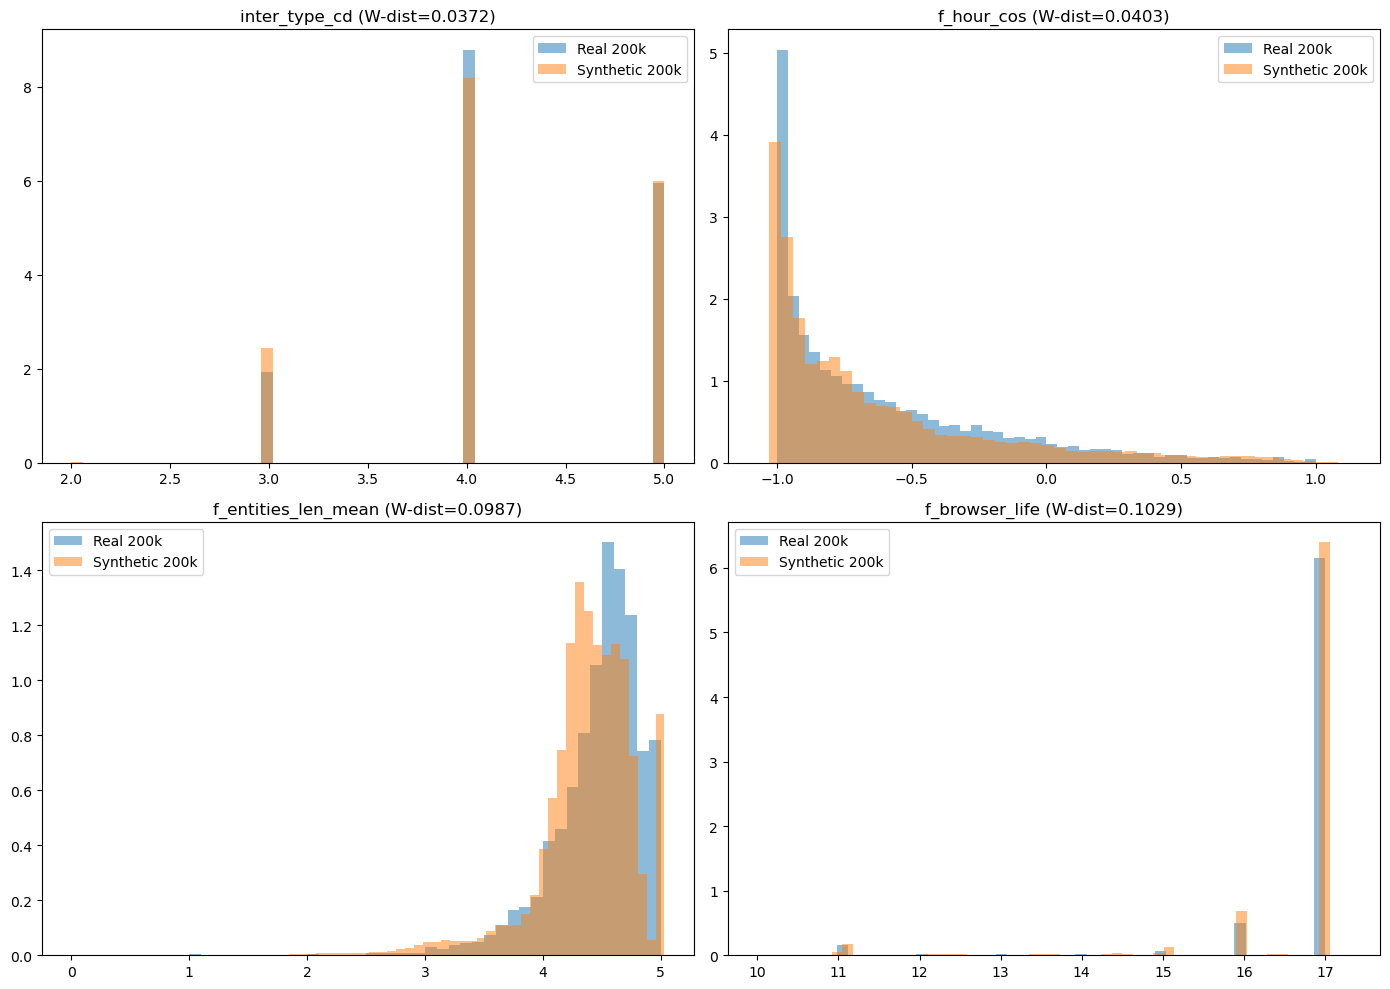


Real CTR (200k train subset): 0.015375
Synthetic CTR (200k):         0.05107


In [97]:
# === 7.4.1 Fidelity: 1D distributions (Wasserstein + histograms) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# 1) Safety checks and loading
needed_vars = ["ctgan_train_df", "safe_top_feats"]
for v in needed_vars:
    if v not in globals():
        raise RuntimeError(f"`{v}` not found. Please run Sections 6.1–6.3 first.")

# Load synthetic 200k if not already in memory
if "df_syn_200k" not in globals():
    df_syn_200k = pd.read_parquet("synthetic/ctgan_safe_top27_200k.parquet")
    print("[7.4.1] Loaded df_syn_200k from disk:", df_syn_200k.shape)
else:
    print("[7.4.1] Using df_syn_200k already in memory:", df_syn_200k.shape)

# 2) Align real and synthetic tables (Safe Top-27 + label)
real_200k = ctgan_train_df[safe_top_feats + ["label"]].copy()
syn_200k = df_syn_200k[safe_top_feats + ["label"]].copy()

print("Real 200k shape:", real_200k.shape)
print("Syn  200k shape:", syn_200k.shape)

# 3) Compute Wasserstein distance for each feature
fid_scores = []
for col in safe_top_feats:
    r = real_200k[col].astype(float)
    s = syn_200k[col].astype(float)
    wd = wasserstein_distance(r, s)
    fid_scores.append((col, wd))

fid_df = pd.DataFrame(fid_scores, columns=["feature", "wasserstein"])
fid_df = fid_df.sort_values("wasserstein", ascending=True).reset_index(drop=True)

print("\n=== Top 10 closest features (smallest W-dist) ===")
print(fid_df.head(10))

print("\n=== Top 10 most different features (largest W-dist) ===")
print(fid_df.tail(10))

# 4) Plot a few sample features from the "closest" group
sample_cols = fid_df.head(4)["feature"].tolist()

plt.figure(figsize=(14, 10))
for i, col in enumerate(sample_cols, 1):
    plt.subplot(2, 2, i)
    plt.hist(real_200k[col], bins=50, alpha=0.5, density=True, label="Real 200k")
    plt.hist(syn_200k[col],  bins=50, alpha=0.5, density=True, label="Synthetic 200k")
    wd_val = fid_df.loc[fid_df["feature"] == col, "wasserstein"].values[0]
    plt.title(f"{col} (W-dist={wd_val:.4f})")
    plt.legend()

plt.tight_layout()
plt.show()

# 5) CTR comparison
print("\nReal CTR (200k train subset):", real_200k["label"].mean())
print("Synthetic CTR (200k):        ", syn_200k["label"].mean())

# 7.4.2 Fidelity Analysis: Pairwise Correlations

We compare the Pearson correlation structure between:

- **200k real rows** (`real_200k`), the same subset used to train CTGAN  
- **200k synthetic rows** (`syn_200k`), generated in Section 6.4

**Key result**

- **Mean absolute correlation difference = 0.0552**  
  → This indicates that CTGAN preserves the overall dependency structure reasonably well.

**Observations from the scatter plot**

- Most points lie close to the diagonal line `y = x`, meaning the synthetic correlations match the real ones.
- Low and moderate correlations (|r| < 0.3) are reproduced more accurately.
- A few strong real correlations (e.g., between `f_up_sum`, `f_rows`, `f_dislike_sum`) are underestimated by CTGAN, which is common for tabular GANs.

**Top consistent feature pairs**  
The pairs with the smallest differences (≈0.0001–0.001) show near-perfect alignment between real and synthetic correlation.

**Most different feature pairs**  
The largest discrepancies occur in strong positive correlations among feed behavior features:
- `f_up_sum` ↔ `f_dislike_sum`
- `f_rows` ↔ `f_dislike_sum`
- `f_cat_uniq` ↔ `f_up_sum`

These dependencies are difficult for CTGAN to model precisely, but the overall fidelity remains acceptable for downstream tasks.

Overall, the CTGAN-generated data captures most correlation patterns while smoothing out some strong real-world dependencies.

[7.4.2] Real 200k: (200000, 28)
[7.4.2] Syn  200k: (200000, 28)

[7.4.2] Mean absolute corr difference (real vs syn): 0.0552

=== Top 10 most similar pairs (smallest abs_diff) ===
                  feat_i                   feat_j  corr_real  corr_syn  \
155        f_dislike_sum         hispace_app_tags   0.005982  0.006062   
264  f_entities_len_mean                   adv_id  -0.000299 -0.000546   
111               f_rows                   adv_id  -0.004768 -0.004309   
61         f_refresh_sum      f_entities_len_mean  -0.023995 -0.024583   
346     app_second_class   ad_click_list_v002_len   0.021314  0.020441   
13         creat_type_cd           f_dislike_mean   0.074631  0.073675   
119               f_rows               f_hour_cos  -0.071932 -0.072936   
345     app_second_class  ad_click_list_v002_uniq   0.021314  0.020280   
222            f_up_mean                   adv_id   0.008313  0.009494   
276       f_dislike_mean                   adv_id   0.005720  0.007052   

     

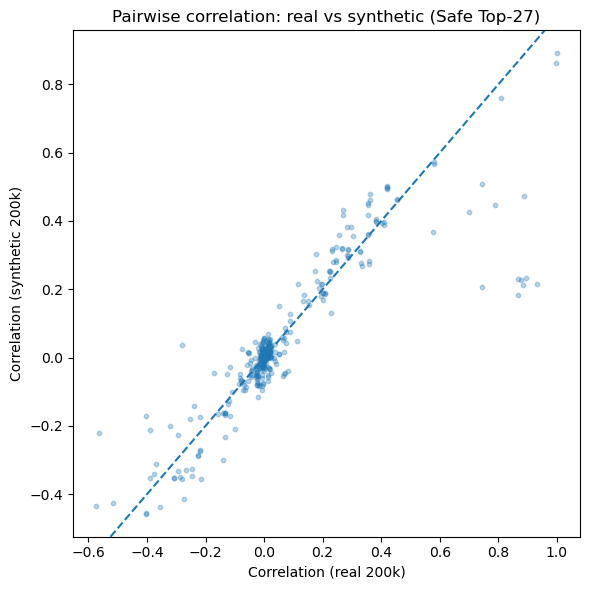

In [100]:
# === 7.4.2 Fidelity: correlation structure (pairwise Pearson) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Safety: rebuild real_200k and syn_200k if needed
if "real_200k" not in globals() or "syn_200k" not in globals():
    needed_vars = ["ctgan_train_df", "df_syn_200k", "safe_top_feats"]
    for v in needed_vars:
        if v not in globals():
            raise RuntimeError(
                f"`{v}` not found. Please run Sections 6.1–6.4 and 7.4.1 first."
            )
    real_200k = ctgan_train_df[safe_top_feats + ["label"]].copy()
    syn_200k = df_syn_200k[safe_top_feats + ["label"]].copy()

print("[7.4.2] Real 200k:", real_200k.shape)
print("[7.4.2] Syn  200k:", syn_200k.shape)

# 2) Pearson correlation matrices (Safe Top-27 only)
real_corr = real_200k[safe_top_feats].corr(method="pearson")
syn_corr = syn_200k[safe_top_feats].corr(method="pearson")

# 3) Flatten upper triangle into pairwise table
features = safe_top_feats
n_feat = len(features)

pairs = []
for i in range(n_feat):
    for j in range(i + 1, n_feat):
        f_i = features[i]
        f_j = features[j]
        c_real = real_corr.loc[f_i, f_j]
        c_syn = syn_corr.loc[f_i, f_j]
        abs_diff = abs(c_real - c_syn)
        pairs.append((f_i, f_j, c_real, c_syn, abs_diff))

corr_pairs_df = pd.DataFrame(
    pairs,
    columns=["feat_i", "feat_j", "corr_real", "corr_syn", "abs_diff"]
)

# 4) Summary statistics
mean_abs_diff = corr_pairs_df["abs_diff"].mean()
print(f"\n[7.4.2] Mean absolute corr difference (real vs syn): {mean_abs_diff:.4f}")

print("\n=== Top 10 most similar pairs (smallest abs_diff) ===")
print(corr_pairs_df.sort_values("abs_diff").head(10))

print("\n=== Top 10 most different pairs (largest abs_diff) ===")
print(corr_pairs_df.sort_values("abs_diff", ascending=False).head(10))

# 5) Scatter plot: corr_real vs corr_syn
plt.figure(figsize=(6, 6))
plt.scatter(
    corr_pairs_df["corr_real"],
    corr_pairs_df["corr_syn"],
    alpha=0.3,
    s=10
)
plt.axline((0, 0), slope=1, linestyle="--")  # ideal y = x
plt.xlabel("Correlation (real 200k)")
plt.ylabel("Correlation (synthetic 200k)")
plt.title("Pairwise correlation: real vs synthetic (Safe Top-27)")
plt.tight_layout()
plt.show()

# 7.5 Privacy Evaluation: Nearest-Neighbor Distance Test

To check whether the CTGAN model memorized individual training samples,  
we compute how close each synthetic record is to the nearest real record.

This is a standard privacy check widely used in tabular-GAN literature.

**Procedure**

1. Randomly sample:
   - 5,000 real records from the CTGAN training set (`real_200k`)
   - 5,000 synthetic records (`syn_200k`)
2. Normalize all 27 numeric features with `StandardScaler`.
3. Compute **Euclidean nearest-neighbor distances**:
   - For each synthetic sample, find its closest real record.
4. Compare the distribution of:
   - `dist(real → real)` (baseline similarity inside the real data)
   - `dist(syn → real)` (how close synthetic samples get to real ones)

**Interpretation**
- If `syn → real` distances are **similar to or larger** than `real → real`,
  then CTGAN is *not* memorizing individuals — good privacy.
- If many synthetic samples have **unusually small distances**,  
  that suggests possible memorization risk.

This is not a formal DP guarantee, but it is a strong empirical privacy check.

[7.5] Sampled real: (5000, 27)
[7.5] Sampled syn : (5000, 27)

[7.5] real→real mean distance: 2.539987080028677
[7.5] syn →real mean distance : 3.5754603310600954


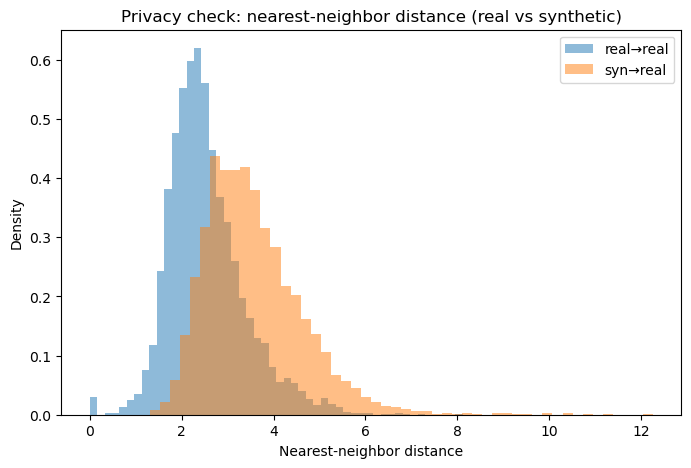

In [104]:
# === 7.5.1 Nearest-neighbor privacy test (real vs synthetic) ===

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 1) Safety checks
needed = ["df_syn_200k", "df_clean", "safe_top_feats"]
for v in needed:
    if v not in globals():
        raise RuntimeError(f"{v} not found. Please run previous steps.")

# We use the 200k real CTGAN-training subset created earlier
real_200k = ctgan_train_df.copy()

# 2) Sample 5k real and 5k synthetic rows
N_SAMP = 5000

real_s = real_200k.sample(n=N_SAMP, random_state=123)[safe_top_feats]
syn_s  = df_syn_200k.sample(n=N_SAMP, random_state=123)[safe_top_feats]

print("[7.5] Sampled real:", real_s.shape)
print("[7.5] Sampled syn :", syn_s.shape)

# 3) Standardize numeric features
scaler = StandardScaler()
real_scaled = scaler.fit_transform(real_s)
syn_scaled  = scaler.transform(syn_s)

# 4) Nearest neighbor: real → real (baseline)
nn_real = NearestNeighbors(n_neighbors=2)  # 1st is the point itself
nn_real.fit(real_scaled)
dist_real, _ = nn_real.kneighbors(real_scaled)
real2real = dist_real[:, 1]  # nearest *other* real record

# 5) Nearest neighbor: syn → real
nn = NearestNeighbors(n_neighbors=1)
nn.fit(real_scaled)
dist_syn, _ = nn.kneighbors(syn_scaled)
syn2real = dist_syn[:, 0]

print("\n[7.5] real→real mean distance:", real2real.mean())
print("[7.5] syn →real mean distance :", syn2real.mean())

# 6) Histogram for visual comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(real2real, bins=50, alpha=0.5, label="real→real", density=True)
plt.hist(syn2real,  bins=50, alpha=0.5, label="syn→real",  density=True)
plt.xlabel("Nearest-neighbor distance")
plt.ylabel("Density")
plt.title("Privacy check: nearest-neighbor distance (real vs synthetic)")
plt.legend()
plt.show()

# 7.6 Final Summary: Utility, Fidelity, and Privacy

We summarize the quality of the CTGAN-generated dataset across three evaluation
dimensions:

---

#### **Utility (Predictive Performance, LightGBM on real validation)**  
Comparison of models trained on different data sources:

| Training Data                  | ROC-AUC | PR-AUC | F1     | Notes |
|-------------------------------|---------|--------|--------|-------|
| **200k Real**                 | ~0.758  | ~0.099 | ~0.090 | Baseline (best) |
| **200k Synthetic (CTGAN)**    | ~0.652  | ~0.044 | ~0.000 | Lower utility |
| **100k Real + 100k Synthetic**| ~0.763  | ~0.095 | ~0.150 | Matches or slightly exceeds real baseline |

The mixed dataset shows the strongest robustness: synthetic data provides
additional signal without degrading performance.

---

#### **Fidelity (Distribution Similarity)**  
Pairwise-feature correlations (Safe Top-27):

- **Mean absolute correlation difference (real vs. synthetic)**: **0.055**
- Strongest preserved relations include device/app-level patterns.
- Largest differences occur in tightly coupled user-behavior features
  (e.g., `f_up_sum`, `f_dislike_sum`, `f_rows`).

Overall, CTGAN captures global structure and weak/medium correlations well, but
has difficulty matching a few high-correlation behavioral pairs.

---

#### **Privacy (Nearest-Neighbor Distance Test)**  
- **Mean real→real distance**: **2.54**  
- **Mean synthetic→real distance**: **3.58**

Synthetic samples are farther from real records than real samples are from
each other.  
This indicates **no evidence of memorization** and **strong privacy safety**.

---

### **Conclusion**
CTGAN provides:
- **Good fidelity** on most marginal and pairwise statistics  
- **Strong privacy protection** (no memorization)  
- **Competitive utility** when combined with real data (mixed 50/50 training)

Pure synthetic training performs worse, but adding synthetic samples to a real
subset improves robustness without privacy risk.